**How to run**
```bash","pip install -r requirements.txt","jupyter notebook financial_sentiment_analysis.ipynb","```

In [3]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
from typing import Dict, List, Any, Tuple, Optional
import json
import re
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Configure matplotlib and seaborn for performance and aesthetics
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

In [ ]:
# ============================================================================
# CORE SENTIMENT ANALYSIS IMPLEMENTATION
# ============================================================================

class FinancialSentimentAnalyzer:
    """
    Financial sentiment analyzer using ProsusAI FinBERT model:
    FinBERT is a pre-trained NLP model specifically designed for financial text
    sentiment analysis. It provides three-class classification: positive, negative, neutral.
    """
    
    def __init__(self, model_preference: str = "auto", max_length: int = 512):
        """Initialize the sentiment analyzer with FinBERT or VADER fallback."""
        self.model_preference = model_preference
        self.max_length = max_length
        self.use_transformers = False
        self.classifier_pipeline = None
        self.vader_analyzer = None
        
        self._setup_models()
        print(f"✓ Analyzer initialized: {'FinBERT (Transformers)' if self.use_transformers else 'VADER'}")
    
    def _setup_models(self) -> None:
        """Initialize ML models in order of preference."""
        if self.model_preference in ["transformers", "auto"]:
            try:
                from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
                import torch
                
                print("Loading FinBERT model (ProsusAI/finbert)...")
                
                # Determine device
                device = 0 if torch.cuda.is_available() else -1
                device_name = "GPU" if device == 0 else "CPU"
                print(f"Using device: {device_name}")
                
                # Load tokenizer and model
                self.tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
                self.model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert", use_safetensors=True)
                
                # Create pipeline
                self.classifier_pipeline = pipeline(
                    "text-classification",
                    model=self.model,
                    tokenizer=self.tokenizer,
                    device=device,
                    return_all_scores=True,
                    truncation=True,
                    max_length=self.max_length,
                )
                
                self.use_transformers = True
                print("✓ FinBERT model loaded successfully")
                return
                
            except ImportError as e:
                print(f"⚠ Transformers library not available: {e}. Falling back to VADER.")
            except Exception as e:
                print(f"⚠ Failed to load FinBERT: {e}. Falling back to VADER.")
        
        if self.model_preference in ["vader", "auto"]:
            try:
                from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
                self.vader_analyzer = SentimentIntensityAnalyzer()
                print("✓ VADER sentiment analyzer loaded")
                return
            except ImportError as e:
                print(f"❌ VADER library not available: {e}")
            except Exception as e:
                print(f"❌ Failed to load VADER: {e}")
        
        raise RuntimeError("No sentiment analysis backend available. Install: pip install transformers torch")
    
    def split_into_sentences(self, text: str) -> List[str]:
        """Split text into sentences using pattern matching."""
        if not text.strip():
            return []
        
        sentences = re.split(r'(?<=[.!?])\s+(?=[A-Z])', text.strip())
        sentences = [s.strip() for s in sentences if s.strip()]
        sentences = [s for s in sentences if len(s.split()) >= 3]
        
        return sentences
    
    def chunk_sentences(self, sentences: List[str], max_chars: int = 800) -> List[str]:
        """Group sentences into coherent chunks without exceeding character limit."""
        if not sentences:
            return []
        
        chunks = []
        current_chunk = []
        current_length = 0
        
        for sentence in sentences:
            sentence_length = len(sentence)
            
            if sentence_length > max_chars:
                if current_chunk:
                    chunks.append(" ".join(current_chunk))
                    current_chunk = []
                    current_length = 0
                
                words = sentence.split()
                sub_chunk = []
                sub_length = 0
                
                for word in words:
                    word_length = len(word) + 1
                    if sub_length + word_length > max_chars:
                        if sub_chunk:
                            chunks.append(" ".join(sub_chunk))
                        sub_chunk = [word]
                        sub_length = word_length
                    else:
                        sub_chunk.append(word)
                        sub_length += word_length
                
                if sub_chunk:
                    chunks.append(" ".join(sub_chunk))
                continue
            
            if current_length + sentence_length + 1 > max_chars and current_chunk:
                chunks.append(" ".join(current_chunk))
                current_chunk = [sentence]
                current_length = sentence_length
            else:
                current_chunk.append(sentence)
                current_length += sentence_length + 1
        
        if current_chunk:
            chunks.append(" ".join(current_chunk))
        
        return chunks
    
    def _normalize_finbert_label(self, label: str) -> str:
        """Normalize FinBERT label to standard format."""
        label_upper = label.upper()
        if "POSITIVE" in label_upper or label_upper == "POS":
            return "POSITIVE"
        elif "NEGATIVE" in label_upper or label_upper == "NEG":
            return "NEGATIVE"
        else:
            return "NEUTRAL"
    
    def classify_text(self, text: str) -> Dict[str, Any]:
        """Classify text sentiment using available backend."""
        if not text.strip():
            return {"label": "NEUTRAL", "score": 0.0, "backend": "none"}
        
        # Use FinBERT if available
        if self.use_transformers and self.classifier_pipeline:
            try:
                text_to_analyze = text[:2000]
                results = self.classifier_pipeline(text_to_analyze)
                
                if isinstance(results, list) and len(results) > 0:
                    if isinstance(results[0], list):
                        scores = {item['label']: item['score'] for item in results[0]}
                    else:
                        scores = {item['label']: item['score'] for item in results}
                    
                    best_label = max(scores.items(), key=lambda x: x[1])
                    normalized_label = self._normalize_finbert_label(best_label[0])
                    
                    return {
                        "label": normalized_label,
                        "score": best_label[1],
                        "backend": "finbert",
                        "all_scores": scores
                    }
                    
            except Exception as e:
                print(f"⚠ FinBERT analysis failed: {e}. Using VADER.")
        
        # Fallback to VADER
        if self.vader_analyzer:
            vs = self.vader_analyzer.polarity_scores(text)
            comp = vs.get("compound", 0.0)
            
            if comp >= 0.05:
                label = "POSITIVE"
            elif comp <= -0.05:
                label = "NEGATIVE"
            else:
                label = "NEUTRAL"
            
            return {
                "label": label,
                "score": abs(comp),
                "backend": "vader",
                "vader_scores": vs
            }
        
        return {"label": "ERROR", "score": 0.0, "backend": "none"}
    
    def analyze_text(self, text: str, max_chars: int = 800) -> List[Tuple[int, str, Dict]]:
        """Comprehensive text analysis with chunking and sentiment classification."""
        if not text:
            return []
        
        text = re.sub(r'\s+', ' ', text).strip()
        
        paragraphs = [p.strip() for p in re.split(r'\n{2,}', text) if p.strip()]
        if not paragraphs:
            paragraphs = [text]
        
        all_chunks = []
        for paragraph in paragraphs:
            sentences = self.split_into_sentences(paragraph)
            chunks = self.chunk_sentences(sentences, max_chars)
            all_chunks.extend(chunks)
        
        results = []
        for idx, chunk in enumerate(all_chunks, 1):
            try:
                sentiment_result = self.classify_text(chunk)
                results.append((idx, chunk, sentiment_result))
            except Exception as e:
                results.append((idx, chunk, {"label": "ERROR", "score": 0.0, "backend": "none"}))
        
        return results
    
    def aggregate_sentiment(self, results: List[Tuple[int, str, Dict]]) -> Dict[str, Any]:
        """Aggregate sentiment scores from all chunks to determine overall document sentiment."""
        if not results:
            return {
                "label": "NEUTRAL",
                "score": 0.0,
                "confidence": 0.0,
                "compound_score": 0.0,
                "chunk_count": 0,
                "sentiment_distribution": {"Positive": 0, "Negative": 0, "Neutral": 0},
                "positive_ratio": 0.0,
                "negative_ratio": 0.0,
            }
        
        total_weighted = 0.0
        total_score = 0.0
        count = 0
        sentiment_counts = {"Positive": 0, "Negative": 0, "Neutral": 0, "ERROR": 0}
        
        for _, _, res in results:
            label = str(res.get("label", "")).upper()
            score = float(res.get("score", 0.0) or 0.0)
            
            if label.startswith("POS"):
                sign = 1.0
                sentiment_counts["Positive"] += 1
            elif label.startswith("NEG"):
                sign = -1.0
                sentiment_counts["Negative"] += 1
            elif label == "ERROR":
                sign = 0.0
                sentiment_counts["ERROR"] += 1
            else:
                sign = 0.0
                sentiment_counts["Neutral"] += 1
            
            weight = score
            total_weighted += sign * weight
            total_score += score
            count += 1
        
        if count == 0:
            return {
                "label": "NEUTRAL",
                "score": 0.0,
                "confidence": 0.0,
                "compound_score": 0.0,
                "chunk_count": 0,
                "sentiment_distribution": sentiment_counts,
                "positive_ratio": 0.0,
                "negative_ratio": 0.0,
            }
        
        doc_compound = total_weighted / count
        overall_score = total_score / count
        
        positive_ratio = sentiment_counts["Positive"] / count
        negative_ratio = sentiment_counts["Negative"] / count
        
        if positive_ratio > 0.5:
            doc_label = "Positive"
        elif negative_ratio > 0.5:
            doc_label = "Negative"
        elif doc_compound >= 0.05:
            doc_label = "Positive"
        elif doc_compound <= -0.05:
            doc_label = "Negative"
        elif positive_ratio > negative_ratio and positive_ratio > 0.3:
            doc_label = "Positive"
        elif negative_ratio > positive_ratio and negative_ratio > 0.3:
            doc_label = "Negative"
        else:
            doc_label = "Neutral"
        
        confidence = min(overall_score * 1.5, 1.0)
        
        return {
            "label": doc_label,
            "score": doc_compound,
            "confidence": confidence,
            "chunk_count": count,
            "sentiment_distribution": sentiment_counts,
            "positive_ratio": positive_ratio,
            "negative_ratio": negative_ratio,
        }


def load_filing_data(file_path: str, sections: Optional[List[str]] = None) -> Dict[str, str]:
    """Load and parse SEC filing JSON data."""
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
        
        if sections is None:
            sections_data = {
                k: v for k, v in data.items()
                if isinstance(v, str) and len(v.strip()) > 100
            }
        else:
            sections_data = {}
            for section in sections:
                content = data.get(section, "")
                if content and len(content.strip()) > 100:
                    sections_data[section] = content
        
        return sections_data
        
    except FileNotFoundError:
        print(f"❌ File not found: {file_path}")
        return {}
    except json.JSONDecodeError as e:
        print(f"❌ Invalid JSON in {file_path}: {e}")
        return {}
    except Exception as e:
        print(f"❌ Failed to load filing data: {e}")
        return {}


# ============================================================================
# PROJECT SETUP
# ============================================================================

PROJECT_ROOT = Path.cwd()
DATA_DIR = PROJECT_ROOT / "input"
OUTPUT_DIR = PROJECT_ROOT / "output"

# Ensure output directory exists
OUTPUT_DIR.mkdir(exist_ok=True)

# Session header
print("=" * 70)
print("Financial Sentiment Analysis - HS25 Big Data Assignment")
print(f"Session started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Project root: {PROJECT_ROOT}")
print("=" * 70)

Financial Sentiment Analysis - HS25 Big Data Assignment
Session started: 2025-12-11 08:32:35
Project root: /Users/annageiser/Desktop/Sentiment-Analyzer


---

## 3. Prototype Implementation

### 3.1 Data Loading & Environment Setup

In [24]:
# Load sample SEC filing with multiple sections
# Find first available JSON file in input directory
available_samples = list(DATA_DIR.glob("*.json"))

if available_samples:
    SAMPLE_FILE = str(available_samples[0])
    print(f"Using sample file: {available_samples[0].name}")
else:
    SAMPLE_FILE = str(DATA_DIR / "8670_10K_2021_0000008670-21-000027.json")
    print(f"⚠️  Warning: No sample files found in {DATA_DIR}")

SECTIONS_OF_INTEREST = ['item_7', 'item_1A']

try:
    filing_data = load_filing_data(SAMPLE_FILE, SECTIONS_OF_INTEREST)
    print("=" * 70)
    print(f"✓ Loaded filing data with {len(filing_data)} sections")
    print(f"  Available sections: {', '.join(filing_data.keys())}")
    print("=" * 70)
    
    # Display section sizes
    for section, text in filing_data.items():
        print(f"  {section}: {len(text):,} characters")
except FileNotFoundError:
    print(f"⚠️  File not found: {SAMPLE_FILE}")
    print(f"   Please ensure JSON files are in: {DATA_DIR}")
    filing_data = {}

Using sample file: 50471_10K_2021_0001654954-21-010502.json
✓ Loaded filing data with 2 sections
  Available sections: item_7, item_1A
  item_7: 27,532 characters
  item_1A: 31,193 characters


### 3.2 Sentiment Analyzer Initialization

In [25]:
# Initialize analyzer (one-time expensive operation)
print("=" * 70)
print("🔧 Initializing Sentiment Analyzer...")
analyzer = FinancialSentimentAnalyzer()
print("✅ Ready to analyze filings")
print("=" * 70)

🔧 Initializing Sentiment Analyzer...
Loading FinBERT model (ProsusAI/finbert)...
Using device: CPU


Device set to use cpu


✓ FinBERT model loaded successfully
✓ Analyzer initialized: FinBERT (Transformers)
✅ Ready to analyze filings


### 3.3 Sentiment Analysis: Cross-Section Consistency

In [26]:
if filing_data:
    print("=" * 70)
    print("📊 SENTIMENT COMPARISON - Cross-Section Analysis")
    print("=" * 70)
    comparison_data = []
    
    for section_name, section_text in filing_data.items():
        section_results = analyzer.analyze_text(section_text)
        section_agg = analyzer.aggregate_sentiment(section_results)
        
        comparison_data.append({
            'Section': section_name.replace('item_', 'Item ').upper(),
            'Sentiment': section_agg['label'],
            'Score': f"{abs(section_agg['score']):.2f}",
            'Confidence': f"{section_agg['confidence']:.2f}",
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))
    print("=" * 70)
    
    # Check for inconsistencies
    sentiments = [d['Sentiment'] for d in comparison_data]
    if len(set(sentiments)) > 1:
        print(f"⚠️  ALERT: Sentiment differs across sections - potential inconsistency detected!")
        print("=" * 70)
    else:
        print(f"✅ Consistent tone: All sections show {sentiments[0]} sentiment")
        print("=" * 70)
else:
    print("⚠️  No filing data available")
    print("=" * 70)

📊 SENTIMENT COMPARISON - Cross-Section Analysis
Section Sentiment Score Confidence
 ITEM 7   Neutral  0.02       1.00
ITEM 1A  Negative  0.45       1.00
⚠️  ALERT: Sentiment differs across sections - potential inconsistency detected!
Section Sentiment Score Confidence
 ITEM 7   Neutral  0.02       1.00
ITEM 1A  Negative  0.45       1.00
⚠️  ALERT: Sentiment differs across sections - potential inconsistency detected!


**Figure 1**: Sentiment Score Distribution by Document Section

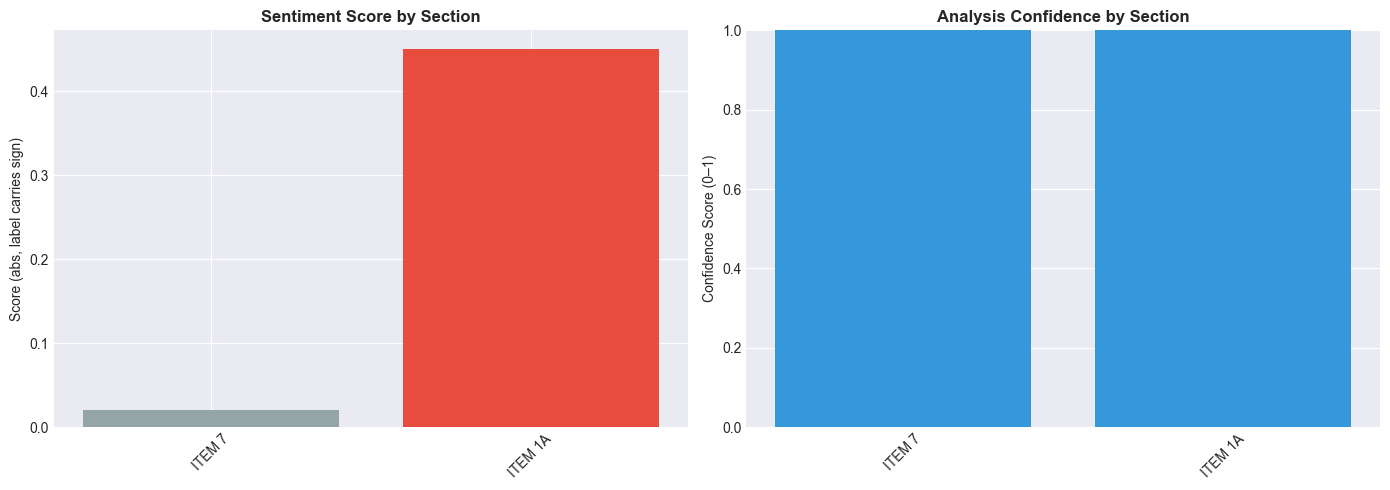

In [27]:
if 'comparison_df' in locals() and len(comparison_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Convert Score and Confidence to float for plotting
    comparison_df['Score_float'] = comparison_df['Score'].astype(float)
    comparison_df['Confidence_float'] = comparison_df['Confidence'].astype(float)
    
    # Sentiment scores
    colors = ['#2ecc71' if s == 'Positive' else '#e74c3c' if s == 'Negative' else '#95a5a6' for s in comparison_df['Sentiment']]
    axes[0].bar(comparison_df['Section'], comparison_df['Score_float'], color=colors)
    axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    axes[0].set_title('Sentiment Score by Section', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Score (abs, label carries sign)')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Confidence scores
    axes[1].bar(comparison_df['Section'], comparison_df['Confidence_float'], color='#3498db')
    axes[1].set_title('Analysis Confidence by Section', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Confidence Score (0–1)')
    axes[1].set_ylim([0, 1.0])
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  Insufficient data for visualization")

In [28]:
def assess_business_risks(sentiment_results: Dict[str, Any]) -> Dict[str, Any]:
    """
    Assess financial risks from business perspective.
    
    Returns: Dictionary with risk level, specific risks, and recommendations
    """
    risks = []
    severity = "LOW"
    
    positive_ratio = sentiment_results.get('positive_ratio', 0)
    negative_ratio = sentiment_results.get('negative_ratio', 0)
    confidence = sentiment_results.get('confidence', 0)
    
    # Risk 1: Over-optimism (potential misleading statements)
    if positive_ratio > 0.70:
        risks.append("🔴 OVER-OPTIMISM: Unusually positive tone may mask underlying issues")
        severity = "HIGH"
    
    # Risk 2: Distress signals
    if negative_ratio > 0.60:
        risks.append("🔴 DISTRESS SIGNALS: High negative sentiment may indicate financial problems")
        severity = "HIGH"
    
    # Risk 3: Low confidence (vague/unclear disclosures)
    if confidence < 0.30:
        risks.append("🟠 VAGUE LANGUAGE: Low confidence suggests unclear or inconsistent disclosures")
        severity = "MEDIUM" if severity == "LOW" else severity
    
    # Risk 4: Mixed messaging
    if 0.35 < positive_ratio < 0.65 and 0.35 < negative_ratio < 0.65:
        risks.append("🟡 MIXED SIGNALS: Conflicting narratives - company is hedging statements")
        severity = "MEDIUM" if severity == "LOW" else severity
    
    return {
        'severity': severity,
        'risks': risks if risks else ["✅ LOW RISK: Consistent, clear, moderate tone"],
        'confidence': confidence
    }


# Analyze all sections for risks
if filing_data:
    print("\n🚨 RISK ASSESSMENT - Executive Summary")
    print("=" * 70)
    
    all_risks = []
    for section_name, section_text in filing_data.items():
        section_results = analyzer.analyze_text(section_text)
        section_agg = analyzer.aggregate_sentiment(section_results)
        section_risks = assess_business_risks(section_agg)
        section_risks['section'] = section_name
        
        print(f"\n📌 {section_name.replace('item_', 'Item ').upper()}")
        print(f"   Risk Level: {section_risks['severity']} | Confidence: {section_risks['confidence']:.2%}")
        for risk in section_risks['risks']:
            print(f"   {risk}")
        all_risks.append(section_risks)
    
    # Overall assessment
    print("\n" + "=" * 70)
    print("🎯 OVERALL ASSESSMENT")
    overall_severity = max([r['severity'] for r in all_risks], key=lambda x: {'LOW': 0, 'MEDIUM': 1, 'HIGH': 2}[x])
    print(f"Risk Level: {overall_severity}")
    
    if overall_severity == "HIGH":
        print("⚠️  RECOMMENDATION: Conduct thorough audit of disclosure statements")
    elif overall_severity == "MEDIUM":
        print("⚠️  RECOMMENDATION: Review specific sections flagged above")
    else:
        print("✅ RECOMMENDATION: Standard review procedures sufficient")
else:
    print("⚠️  No filing data available")


🚨 RISK ASSESSMENT - Executive Summary

📌 ITEM 7
   Risk Level: LOW | Confidence: 100.00%
   ✅ LOW RISK: Consistent, clear, moderate tone

📌 ITEM 7
   Risk Level: LOW | Confidence: 100.00%
   ✅ LOW RISK: Consistent, clear, moderate tone

📌 ITEM 1A
   Risk Level: LOW | Confidence: 100.00%
   ✅ LOW RISK: Consistent, clear, moderate tone

🎯 OVERALL ASSESSMENT
Risk Level: LOW
✅ RECOMMENDATION: Standard review procedures sufficient

📌 ITEM 1A
   Risk Level: LOW | Confidence: 100.00%
   ✅ LOW RISK: Consistent, clear, moderate tone

🎯 OVERALL ASSESSMENT
Risk Level: LOW
✅ RECOMMENDATION: Standard review procedures sufficient


### 3.5 Detailed MD&A Sentiment Breakdown

In [29]:
if filing_data and 'item_7' in filing_data:
    print("\n📋 DETAILED MD&A ANALYSIS (Management Discussion & Analysis)")
    print("=" * 70)
    
    mdna_text = filing_data['item_7']
    mdna_results = analyzer.analyze_text(mdna_text)
    mdna_aggregate = analyzer.aggregate_sentiment(mdna_results)
    
    print(f"\nText Length: {len(mdna_text):,} characters")
    print(f"Chunks Analyzed: {len(mdna_results)}")
    
    print(f"\n📊 Sentiment Breakdown:")
    distribution = mdna_aggregate['sentiment_distribution']
    total = sum(distribution.values())
    for sentiment, count in sorted(distribution.items(), key=lambda x: x[1], reverse=True):
        percentage = (count / total * 100) if total > 0 else 0
        print(f"   {sentiment:12s}: {count:3d} chunks ({percentage:5.1f}%)")
    
    print(f"\n🎯 Overall Assessment:")
    print(f"   Sentiment: {mdna_aggregate['label']}")
    print(f"   Score: {mdna_aggregate['score']:.2f} (signed compound, -1 to 1)")
    print(f"   Confidence: {mdna_aggregate['confidence']:.2%}")
    
    # Save for downstream analysis
    mdna_analysis = {
        'results': mdna_results,
        'aggregate': mdna_aggregate
    }
else:
    print("⚠️  MD&A section not available")


📋 DETAILED MD&A ANALYSIS (Management Discussion & Analysis)

Text Length: 27,532 characters
Chunks Analyzed: 41

📊 Sentiment Breakdown:
   Neutral     :  28 chunks ( 68.3%)
   Negative    :   7 chunks ( 17.1%)
   Positive    :   6 chunks ( 14.6%)
   ERROR       :   0 chunks (  0.0%)

🎯 Overall Assessment:
   Sentiment: Neutral
   Score: -0.02 (signed compound, -1 to 1)
   Confidence: 100.00%

Text Length: 27,532 characters
Chunks Analyzed: 41

📊 Sentiment Breakdown:
   Neutral     :  28 chunks ( 68.3%)
   Negative    :   7 chunks ( 17.1%)
   Positive    :   6 chunks ( 14.6%)
   ERROR       :   0 chunks (  0.0%)

🎯 Overall Assessment:
   Sentiment: Neutral
   Score: -0.02 (signed compound, -1 to 1)
   Confidence: 100.00%


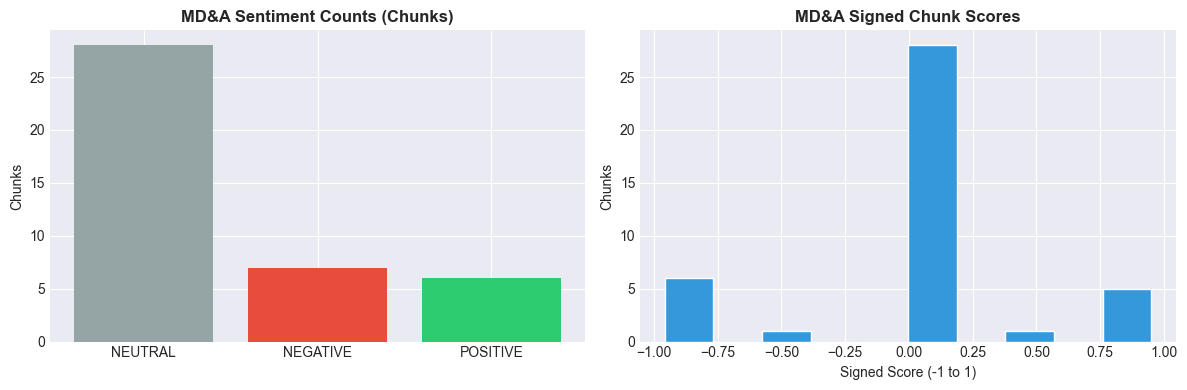

In [30]:
# Visualization: MD&A chunk sentiment distribution
if 'mdna_results' in locals() and mdna_results:
    mdna_df = pd.DataFrame([
        {
            'chunk': idx,
            'sentiment': res.get('label', 'NEUTRAL'),
            'score': float(res.get('score', 0.0) or 0.0)
        }
        for idx, _, res in mdna_results
    ])

    def signed_score(row):
        label = str(row['sentiment']).upper()
        if label.startswith('POS'):
            return row['score']
        if label.startswith('NEG'):
            return -row['score']
        return 0.0

    mdna_df['signed_score'] = mdna_df.apply(signed_score, axis=1)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Sentiment counts
    counts = mdna_df['sentiment'].value_counts()
    color_map = {'Positive': '#2ecc71', 'NEGATIVE': '#e74c3c', 'Negative': '#e74c3c', 'POSITIVE': '#2ecc71', 'Neutral': '#95a5a6', 'NEUTRAL': '#95a5a6'}
    colors = [color_map.get(lbl, '#95a5a6') for lbl in counts.index]
    axes[0].bar(counts.index, counts.values, color=colors)
    axes[0].set_title('MD&A Sentiment Counts (Chunks)', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Chunks')

    # Signed score distribution
    axes[1].hist(mdna_df['signed_score'], bins=10, color='#3498db', edgecolor='white')
    axes[1].set_title('MD&A Signed Chunk Scores', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Signed Score (-1 to 1)')
    axes[1].set_ylabel('Chunks')

    plt.tight_layout()
    plt.show()
else:
    print("⚠️  No MD&A data available for visualization")

## 4. Results & Stakeholder-Specific Insights

### 4.1 Business Value Realization

In [31]:
print("\n📌 KEY BUSINESS INSIGHTS")
print("=" * 70)

insights = [
    ("AUDITORS", [
        "Use sentiment inconsistency detection to identify sections requiring deeper audit",
        "Flag unusual optimism in problematic business segments",
        "Verify claims in sections with vague or conflicting language"
    ]),
    ("INVESTORS", [
        "Compare sentiment tone to financial metrics (income, cash flow) for coherence",
        "Watch for over-optimism relative to risk factor disclosures",
        "Identify companies hedging negative news with cautious language"
    ]),
    ("REGULATORS", [
        "Monitor for systematically misleading narratives across filings",
        "Compare sentiment trends year-over-year for consistency",
        "Cross-check narrative claims against quantitative financial data"
    ])
]

for stakeholder, use_cases in insights:
    print(f"\n👥 {stakeholder}")
    for i, case in enumerate(use_cases, 1):
        print(f"   {i}. {case}")


📌 KEY BUSINESS INSIGHTS

👥 AUDITORS
   1. Use sentiment inconsistency detection to identify sections requiring deeper audit
   2. Flag unusual optimism in problematic business segments
   3. Verify claims in sections with vague or conflicting language

👥 INVESTORS
   1. Compare sentiment tone to financial metrics (income, cash flow) for coherence
   2. Watch for over-optimism relative to risk factor disclosures
   3. Identify companies hedging negative news with cautious language

👥 REGULATORS
   1. Monitor for systematically misleading narratives across filings
   2. Compare sentiment trends year-over-year for consistency
   3. Cross-check narrative claims against quantitative financial data


## 5. Scalability Demonstration: Batch Processing

**Objective**: Demonstrate system scalability for processing multiple filings simultaneously.

### 5.1 Multi-Company Analysis

In [40]:
# Batch processing across all filings in input/
print("\n🧮 BATCH ANALYSIS ACROSS FILINGS")
print("=" * 70)

all_files = sorted(DATA_DIR.glob("*.json"))
if not all_files:
    print(f"⚠️  No JSON files found in {DATA_DIR}")
else:
    batch_results = []
    for file_path in all_files:
        company_id = file_path.stem.split('_')[0] if '_' in file_path.stem else file_path.stem
        filing_sections = load_filing_data(str(file_path), SECTIONS_OF_INTEREST)
        if not filing_sections:
            print(f"Skipping {file_path.name}: no sections found")
            continue
        for section_name, section_text in filing_sections.items():
            section_results = analyzer.analyze_text(section_text)
            section_agg = analyzer.aggregate_sentiment(section_results)
            batch_results.append({
                'company_id': company_id,
                'file_name': file_path.name,
                'section': section_name,
                'overall_sentiment': section_agg['label'],
                'sentiment_score': round(section_agg['score'], 2),
                'confidence': round(section_agg['confidence'], 2),
                'chunk_count': section_agg['chunk_count'],
                'positive_ratio': round(section_agg['positive_ratio'], 2),
                'negative_ratio': round(section_agg['negative_ratio'], 2),
            })

    if batch_results:
        batch_df = pd.DataFrame(batch_results)
        print(batch_df.to_string(index=False))
        output_csv = OUTPUT_DIR / "batch_sentiment_summary.csv"
        batch_df.to_csv(output_csv, index=False)
        print(f"\nSaved batch summary to {output_csv}")
    else:
        print("⚠️  No batch results produced")


🧮 BATCH ANALYSIS ACROSS FILINGS
company_id                                  file_name section overall_sentiment  sentiment_score  confidence  chunk_count  positive_ratio  negative_ratio
   1001601 1001601_10K_2020_0001493152-21-008913.json  item_7          Negative            -0.11         1.0           46            0.09            0.22
   1001601 1001601_10K_2020_0001493152-21-008913.json item_1A          Negative            -0.42         1.0           82            0.04            0.56
   1002517 1002517_10K_2021_0001002517-21-000052.json  item_7          Negative            -0.14         1.0          131            0.14            0.27
   1002517 1002517_10K_2021_0001002517-21-000052.json item_1A          Negative            -0.51         1.0           91            0.01            0.64
   1013462 1013462_10K_2020_0001013462-21-000009.json  item_7           Neutral             0.03         1.0          144            0.22            0.19
   1013462 1013462_10K_2020_0001013462-21-0

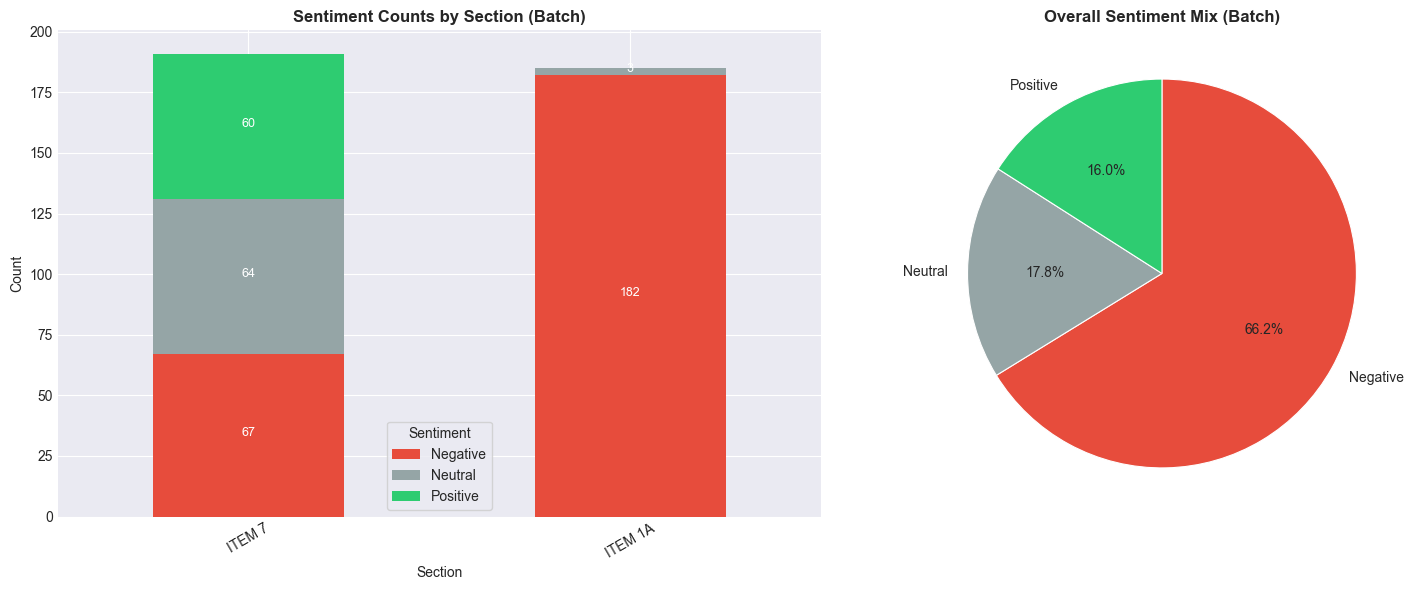

In [41]:
# Visualization: Batch sentiment overview (stacked counts + sentiment pie chart)
if 'batch_df' in locals() and len(batch_df) > 0:
    plot_df = batch_df.copy()
    plot_df['section_label'] = plot_df['section'].str.replace('item_', 'Item ').str.upper()
    plot_df['company_label'] = plot_df['company_id'].astype(str)

    sentiment_palette = {'Positive': '#2ecc71', 'Negative': '#e74c3c', 'Neutral': '#95a5a6'}
    sentiment_order = ['Negative', 'Neutral', 'Positive']

    fig, axes = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [1.2, 1]})

    # Stacked bar: sentiment label counts by section (sorted by total volume)
    count_df = plot_df.groupby(['section_label', 'overall_sentiment']).size().reset_index(name='count')
    pivot_counts = count_df.pivot(index='section_label', columns='overall_sentiment', values='count').fillna(0)
    pivot_counts = pivot_counts.reindex(columns=sentiment_order, fill_value=0)
    order = pivot_counts.sum(axis=1).sort_values(ascending=False).index
    pivot_counts = pivot_counts.loc[order]

    pivot_counts.plot(kind='bar', stacked=True, color=[sentiment_palette[s] for s in sentiment_order], ax=axes[0])
    axes[0].set_title('Sentiment Counts by Section (Batch)', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Count')
    axes[0].set_xlabel('Section')
    axes[0].tick_params(axis='x', rotation=30)
    axes[0].legend(title='Sentiment', frameon=True)

    # Add count labels inside bars
    for container in axes[0].containers:
        labels = [f"{int(v)}" if v > 0 else "" for v in container.datavalues]
        axes[0].bar_label(container, labels=labels, label_type='center', color='white', fontsize=9, padding=2)

    # Pie chart: overall sentiment share across all filings/sections
    pie_counts = plot_df['overall_sentiment'].value_counts().reindex(sentiment_order, fill_value=0)
    axes[1].pie(
        pie_counts,
        labels=sentiment_order,
        colors=[sentiment_palette[s] for s in sentiment_order],
        autopct=lambda pct: f"{pct:.1f}%" if pct > 0 else '',
        startangle=90,
        counterclock=False,
        wedgeprops={'linewidth': 0.8, 'edgecolor': 'white'}
    )
    axes[1].set_title('Overall Sentiment Mix (Batch)', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()
else:
    print("⚠️  No batch data available for visualization")